<h1>Script to plot zonal mean response of CMIP6 models</h1>

In [327]:
from itertools import chain
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import re

# Set some plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

<h2>Extract the name for all models and each of their members for historical simulations </h2>
<h4>- Model names are stored within a dictionary along with their members which are in turn stored within a list </h2>

In [ ]:
hist_model_data_dir = "/badc/cmip6/data/CMIP6/CMIP/*/*/historical/*/Amon/ua/gn/latest/"
hist_data_in_dir_paths = glob(hist_model_data_dir)
hist_models = {}
for i in range(0,len(hist_data_in_dir_paths)):
    model_name = hist_data_in_dir_paths[i].split(sep='/')[7]
    if model_name not in hist_models:
        hist_models[model_name] = [hist_data_in_dir_paths[i].split(sep='/')[9]] # assign member to list
    else:
        hist_models[model_name].append(hist_data_in_dir_paths[i].split(sep='/')[9])
        
# print(hist_models)

<h2>Extract the name for all models and each of their members for RCP8.5 simulations </h2>

In [329]:
rcp85_data_dir = "/badc/cmip6/data/CMIP6/ScenarioMIP/*/*/ssp585/*/Amon/ua/gn/latest"
data_in_dir_paths = glob(rcp85_data_dir)
rcp85_models = {}
for i in range(0,len(data_in_dir_paths)):
    model_name = data_in_dir_paths[i].split(sep='/')[7]
    if model_name not in rcp85_models:
        rcp85_models[model_name] = [data_in_dir_paths[i].split(sep='/')[9]] # assign member to list
    else:
        rcp85_models[model_name].append(data_in_dir_paths[i].split(sep='/')[9])

# print(rcp85_models)

<h2>Read in zonal mean data and calculate the mean zonal response </h2>

- Data was originally produced by python scripts: 
    - calculate_CMIP6_historical_zonal_means.py 
    - calculate_CMIP6_rcp85_zonal_means.py 

In [ ]:
diff_all_models = []
hist_mean_all_models = []
rcp85_mean_all_models = []
model_name_fig = []
n_ens = []
dt=0 # count number of models with the same members in HIST and RCP85
for model in hist_models:
    #model = list(hist_models.keys())[2]
    dm=0 # count the number of members per model in HIST and RCP85
    for member in hist_models[model]:
        if model in list(rcp85_models.keys()) and member in rcp85_models[model] and model not in ['MCM-UA-1-0','UKESM1-0-LL']:
            #print(model, member, dt)
            indir='/home/users/cjm317/CMIP6_Hackathon/Historical'
            infile=f'{model}_{member}_DJF_zonal_mean_ua_Amon_1981-2010.nc'
            zm_hist = xr.open_mfdataset(f'{indir}/{infile}')

            indir='/home/users/cjm317/CMIP6_Hackathon/RCP85'
            infile=f'{model}_{member}_DJF_zonal_mean_ua_Amon_2070-2099.nc'
            zm_rcp85 = xr.open_mfdataset(f'{indir}/{infile}')

            if dm==0:
                dt+=1
                diff = zm_rcp85 - zm_hist
                model_name_fig.append(model)
                hist_mean = zm_hist
                rcp85_mean = zm_rcp85
            else:
                diff_tmp = zm_hist - zm_rcp85
                diff = diff + diff_tmp
                hist_mean = hist_mean + zm_hist
                rcp85_mean = rcp85_mean + zm_rcp85
            dm+=1                

    if dm > 0:
        n_ens.append(dm)
        diff = diff/dm # divide by dm (number of members) to obtain the ensemble average zonal mean response
        diff_all_models.append(diff)
        
        hist_mean = hist_mean/dm
        hist_mean_all_models.append(hist_mean)
        
        rcp85_mean = rcp85_mean/dm
        rcp85_mean_all_models.append(rcp85_mean)

<h2>Plot the mean zonal response for each model and overlay the historical zonal winds </h2>

<ipython-input-384-8dd3e0e76a2d>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds_i.lat, ds_i.plev, ds_i.ua.values, cmap='RdBu_r',vmin=-.8,vmax=0.8)


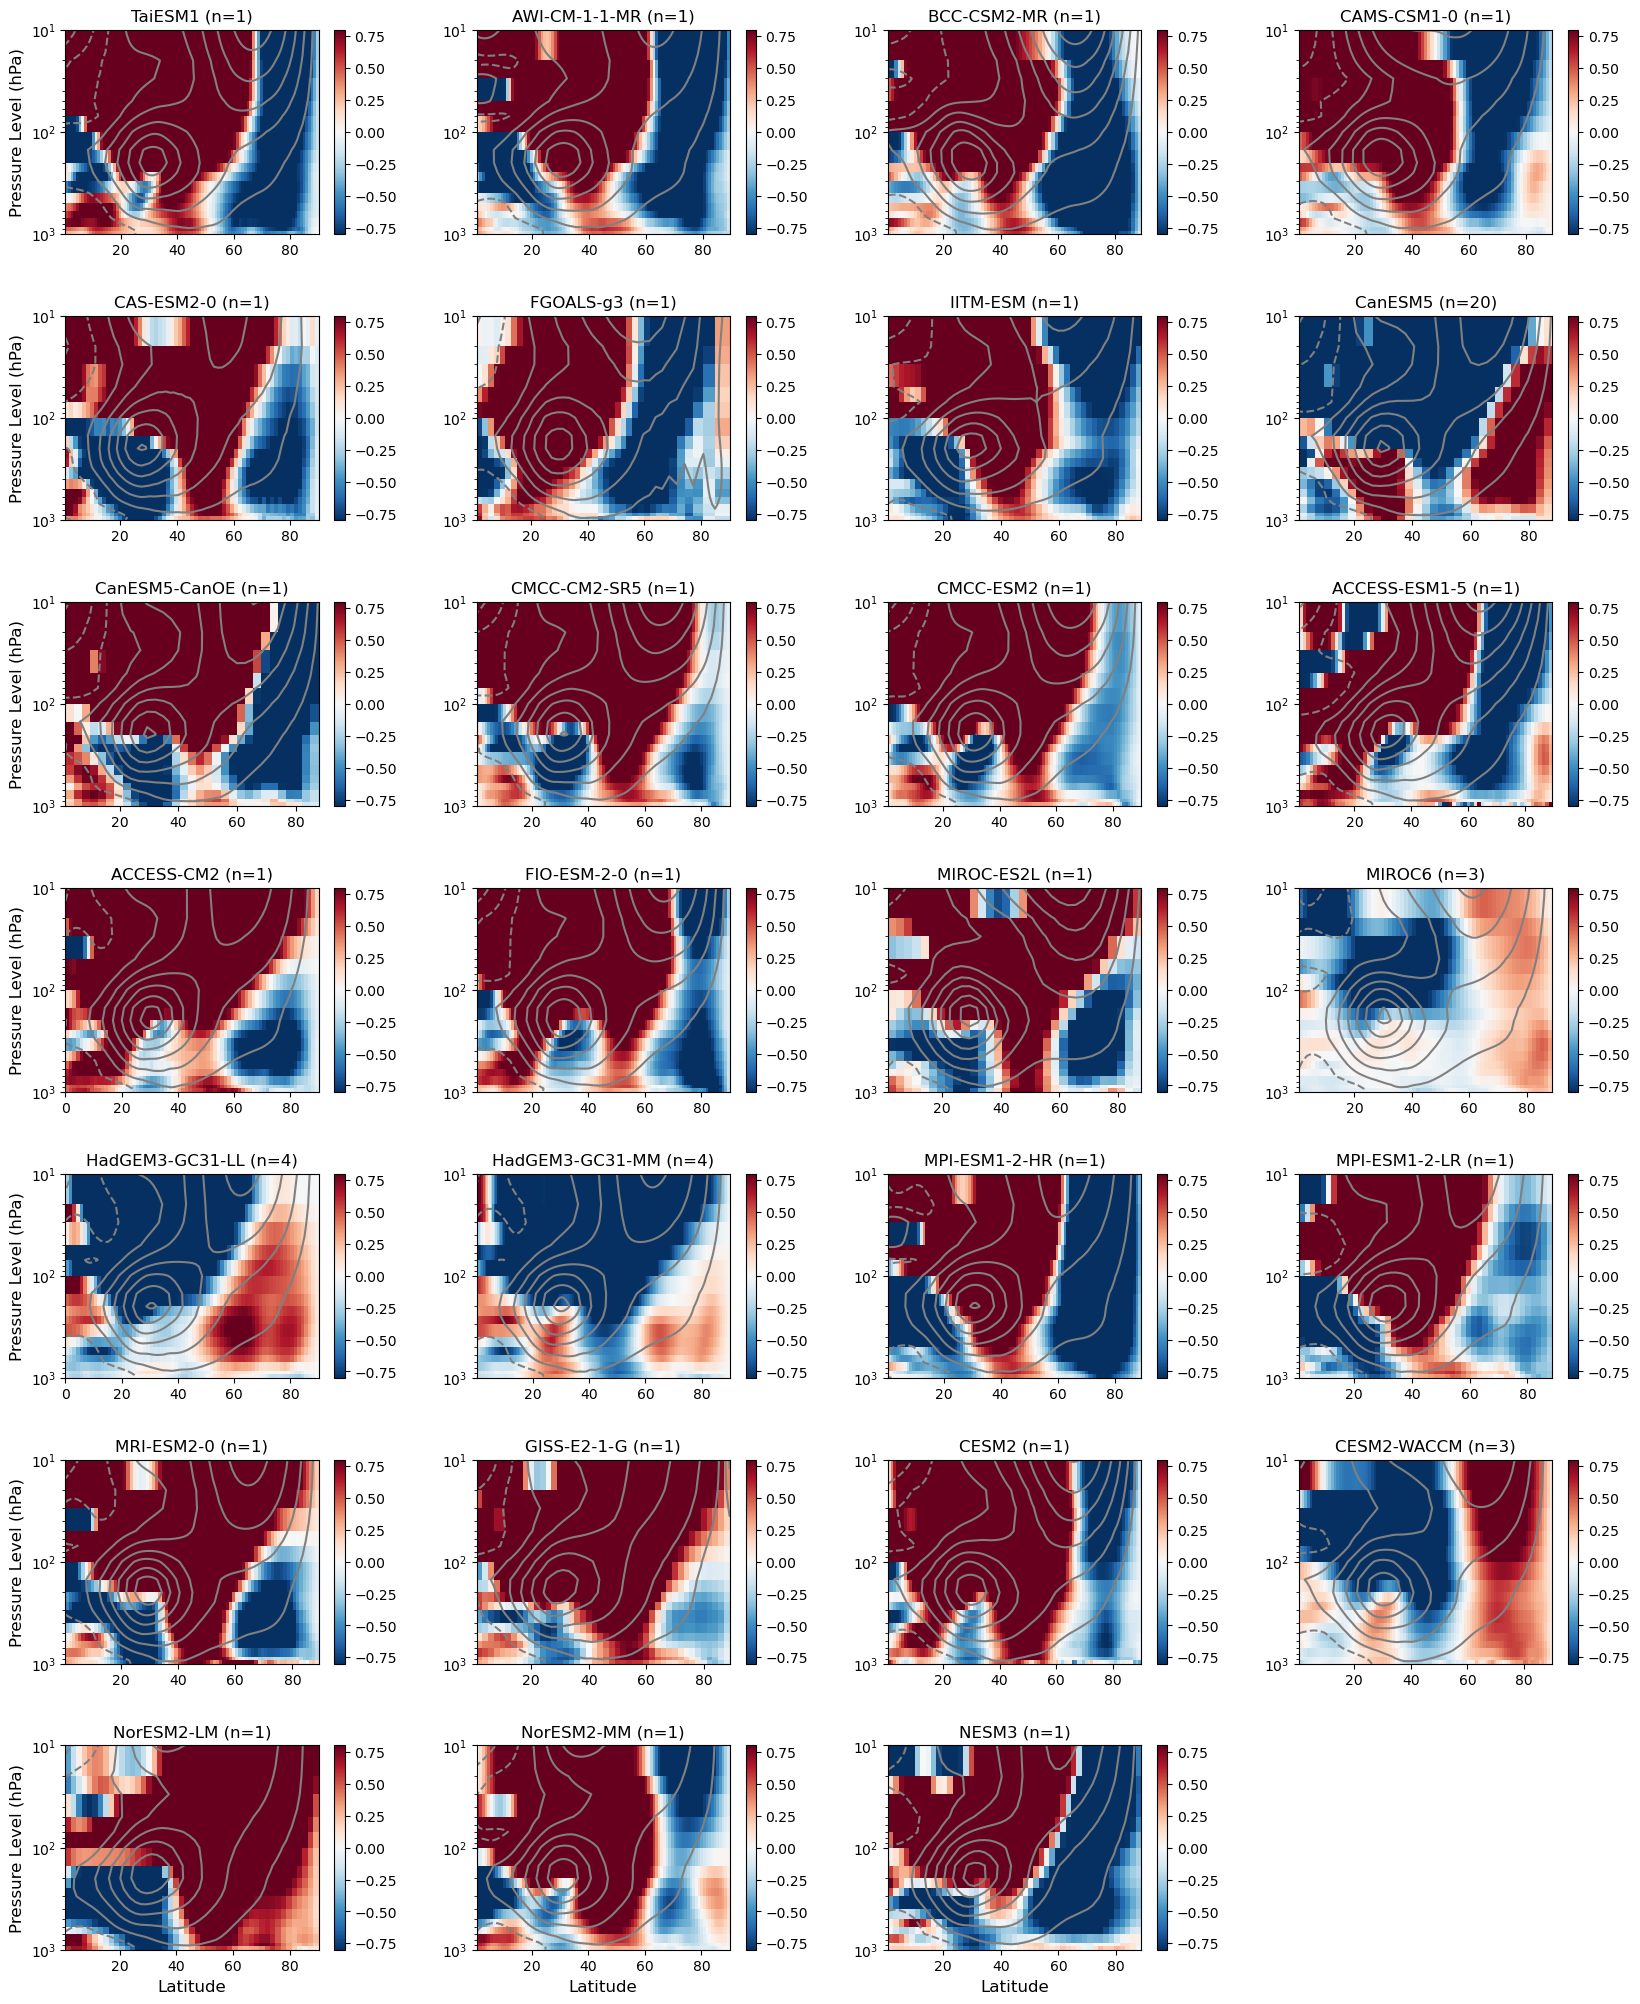

In [384]:
cmap = plt.get_cmap('RdBu_r')

fig, axes = plt.subplots(nrows=7, ncols=4,figsize=(20, 24)) #, figsize=(15,15))
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
for i in range(0,27): 
    ds_i = diff_all_models[i]
    ds_h = hist_mean_all_models[i]
    ax = plt.subplot(7,4,i+1)
    ds_i['plev'] = ds_i.plev.values/100 # convert Pa to hPa
    ds_h['plev'] = ds_h.plev.values/100 # convert Pa to hPa
    plt.pcolormesh(ds_i.lat, ds_i.plev, ds_i.ua.values, cmap='RdBu_r',vmin=-.8,vmax=0.8)
    plt.yscale('log')
    plt.contour(ds_h.lat, ds_h.plev, ds_h.ua.values,colors='grey', levels=np.arange(-50,60,8))
    if i in (0,4,8,12,16,20,24):
        plt.ylabel('Pressure Level (hPa)',fontsize=12)
    if i in (24,25,26):
        plt.xlabel('Latitude',fontsize=12)
    plt.yscale('log')
    
    plt.ylim([1000, 10])
    plt.title(f'{model_name_fig[i]} (n={n_ens[i]})')

    normalize=matplotlib.colors.Normalize(vmin=-0.8, vmax=0.8)
    cax, _ = matplotlib.colorbar.make_axes(ax, location = "right", pad=0.05)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize,orientation="vertical")
    cbar.ax.tick_params(labelsize=10)


fig.delaxes(axes[6][3])
#figdir = '/home/users/cjm317'
#fig.savefig(f'{figdir}/cmip6_27_model_zonal_mean_diff_scen585_2070-2099_hist_1981-2010_smaller_range.png', dpi=100, transparent=False, bbox_inches='tight', pad_inches=0.1)

